## Trajectory tests

Compare speed of processing LAMMPS trajectories using different modules

In [10]:
import pyscal.core as pc
from pyscal.core import Trajectory
import pyscal.traj_process as ptp
import dask.bag as db
from ase.io import read
import matplotlib.pyplot as plt

---

### Approach 1 - `pyscal.traj_process`

Use pyscal `traj_process` to split the file. Reading is done in a second step.

In [3]:
%%timeit
files = ptp.split_trajectory("traj.light")

3.37 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Advantages
- Quite fast
- Does not read the complete file into memory

### Disadvantages
- Creates a number of small files into which the larger file is written
- Affects the hard disk space

## Approach 2 - `dask.bag`

Reading the file in dask is a two step approach. First a lazy iterator is created, then the data is computed.

In [4]:
bag = db.read_text("traj.light")

In [5]:
%%timeit
x = bag.compute()

474 ms ± 44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Advantages
- None

### Disadvantages
- Super slow
- Reads the whole file at the same time

## Approach 3 - `ase.io.read`

In [6]:
%%timeit
d = read("traj.light", index=":", format="lammps-dump-text")

39 ms ± 953 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Advantages
- No temporary files created
- Reasonably fast

### Disadvantages
- Reads the whole file at the same time
- Cannot write dump files

## Approach 4 - `Trajectory` class from pyscal

The `Trajectory` class creates a object which gets basic information about the file without reading in the file at all. The reading is only done as when required.

In [7]:
traj = Trajectory("traj.light")

Trajectory module supports indexing

In [8]:
sl = traj[:]

In [9]:
%%timeit
sl.to_file("dump")

2.62 ms ± 45.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Advantages
- Fastest approach
- At most only one snapshot is kept in memory
- No temporary files

### Disadvantages
- Only supports lammps files

Text(0, 0.5, 'Time (ms)')

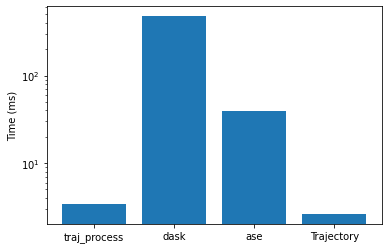

In [15]:
times = [3.37, 474, 39, 2.62]
names = ["traj_process", "dask", "ase", "Trajectory"]
plt.bar(range(len(times)), times, log=True, tick_label=names)
plt.ylabel("Time (ms)")

Test for a larger file. We will exclude `dask` as it is pretty slow.

In [16]:
%%timeit
files = ptp.split_trajectory("traj.3.dat")

345 ms ± 9.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
d = read("traj.3.dat", index=":", format="lammps-dump-text")

5.3 s ± 59.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
traj = Trajectory("traj.3.dat")
sl = traj[:]

In [22]:
%%timeit
sl.to_file("dump")

374 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0, 0.5, 'Time (ms)')

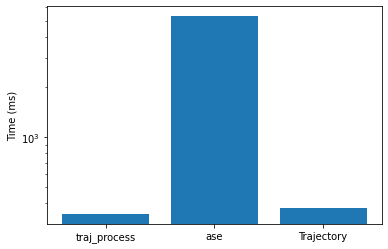

In [23]:
times = [345, 5300, 374]
names = ["traj_process", "ase", "Trajectory"]
plt.bar(range(len(times)), times, log=True, tick_label=names)
plt.ylabel("Time (ms)")

Trajectory performs quite well even for the larger file. Main advantage - it does not write until absolutely necessary! 